In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
main_path = Path('..').resolve()
sys.path.append(str(main_path))

import seaborn as sns
from src.dataset import MetaStockDataset
from src.utils import ARGProcessor
import torch
import matplotlib.pyplot as plt
torch.__version__

'1.11.0+cu113'

In [2]:
setting_file = Path('.') / 'acl.yml'

meta_args = ARGProcessor(setting_file=setting_file)
data_kwargs = meta_args.get_args(cls=MetaStockDataset)

meta_train = MetaStockDataset(meta_type='train', **data_kwargs)
meta_valid_time = MetaStockDataset(meta_type='valid-time', **data_kwargs)
meta_valid_stock = MetaStockDataset(meta_type='valid-stock', **data_kwargs)
meta_valid_mix = MetaStockDataset(meta_type='valid-mix', **data_kwargs)
meta_test_time = MetaStockDataset(meta_type='test-time', **data_kwargs)
meta_test_stock = MetaStockDataset(meta_type='test-stock', **data_kwargs)
meta_test_mix = MetaStockDataset(meta_type='test-mix', **data_kwargs)

Processing data and candidates for test-mix: 100%|██████████| 9/9 [00:00<00:00, 95.75it/s]


In [3]:
all_data = meta_train.generate_tasks()
all_data

StockDataDict(T=5, numpy)
- query: (64, 1, 5, 11)
- query_labels: (64,)
- support: (64, 2, 5, 11)
- support_labels: (128,)

In [4]:
all_data.to('cpu')
all_data

StockDataDict(T=5, tensor.cpu)
- query: torch.Size([64, 1, 5, 11])
- query_labels: torch.Size([64])
- support: torch.Size([64, 2, 5, 11])
- support_labels: torch.Size([128])

In [5]:
all_data.numpy()
all_data

StockDataDict(T=5, numpy)
- query: (64, 1, 5, 11)
- query_labels: (64,)
- support: (64, 2, 5, 11)
- support_labels: (128,)

In [6]:
all_data['query'][..., 0].reshape(-1).shape

(320,)

In [ ]:
meta_train.meta_type

In [33]:
def draw_density(ds):
    all_data = ds.generate_tasks()
    fig, axes = plt.subplots(11, 2, figsize=(10, 16))
    for i in range(11):
        for t in range(2):
            
            f1_q = all_data['query'][..., i].reshape(-1)
            f1_s = all_data['support'][:, t, :, i].reshape(-1)
            sns.histplot(data=f1_q, ax=axes[i, t], color="blue", label='query', alpha=0.2)
            sns.histplot(data=f1_s, ax=axes[i, t], color="red", label='support', alpha=0.2)
            axes[i, t].legend()
            if i == 0:
                axes[i, t].set_title(f'Class: {t}')
    fig.suptitle(f'{ds.meta_type}')
    plt.tight_layout()
    plt.show()

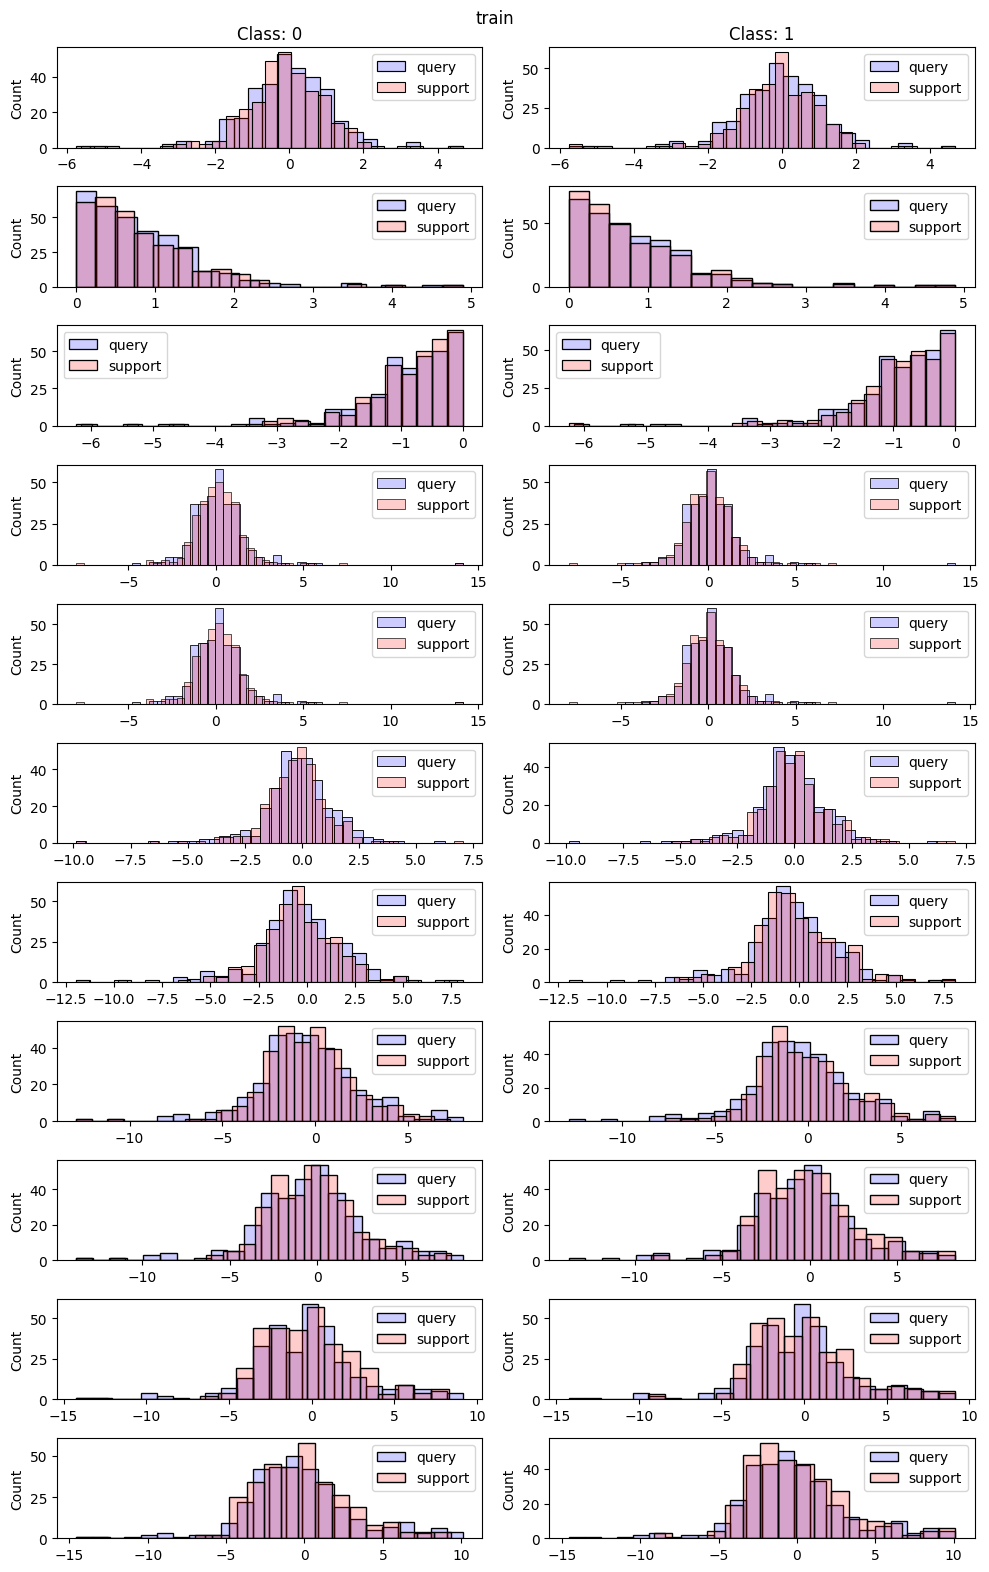

In [34]:
draw_density(ds=meta_train)

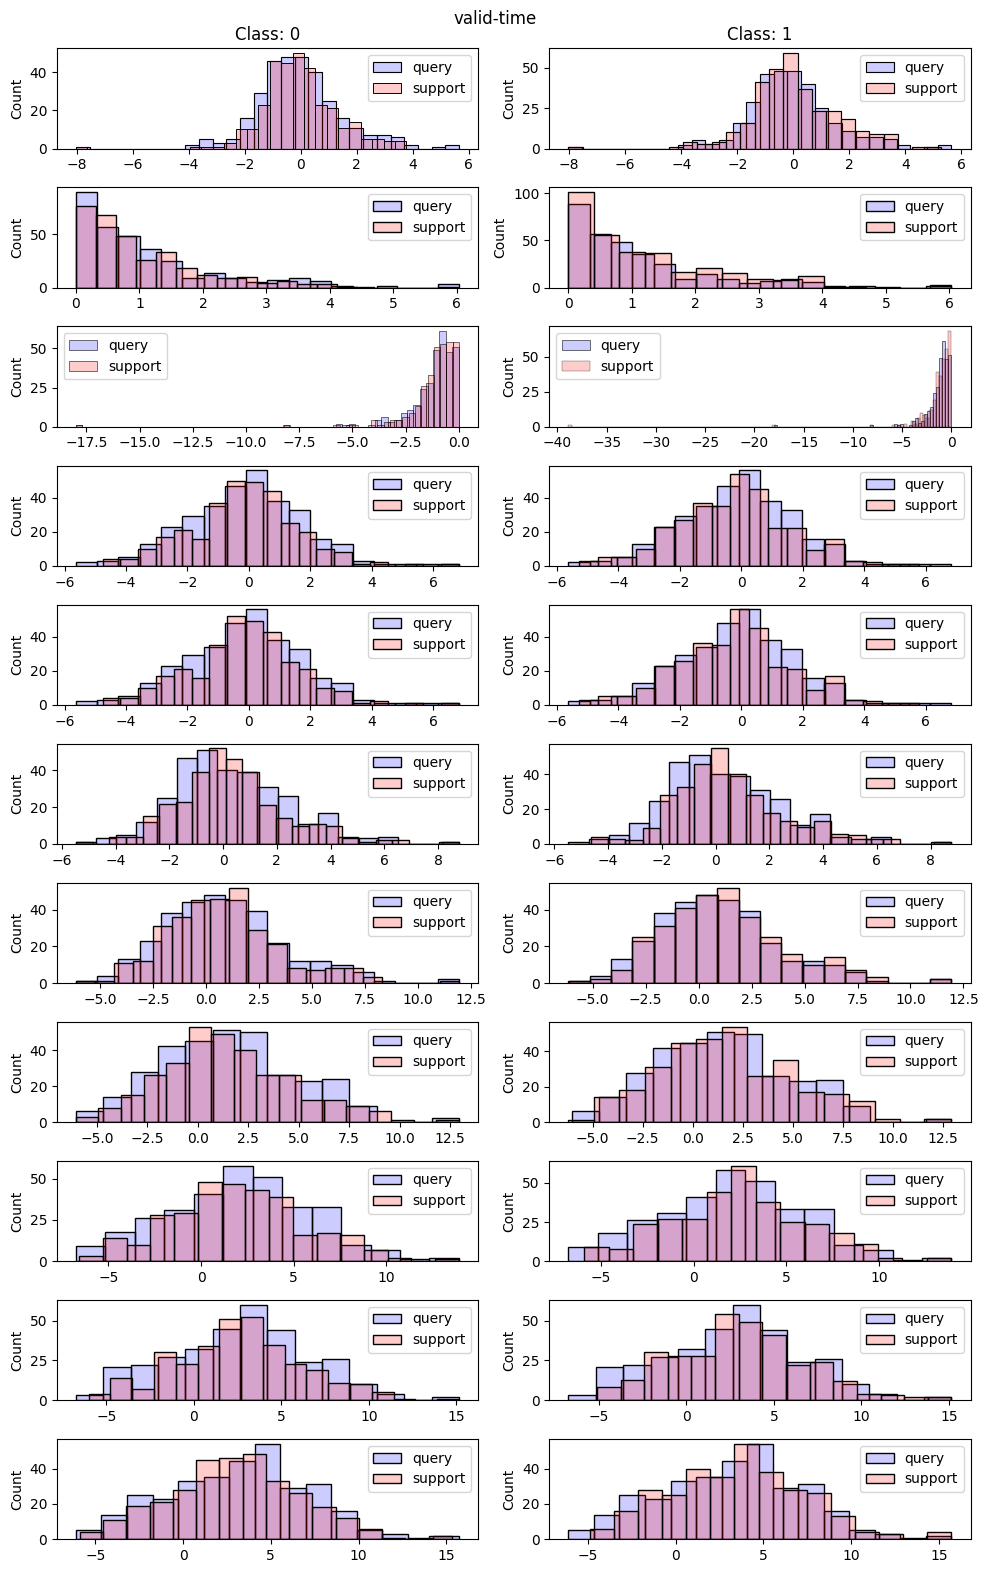

In [35]:
draw_density(ds=meta_valid_time)

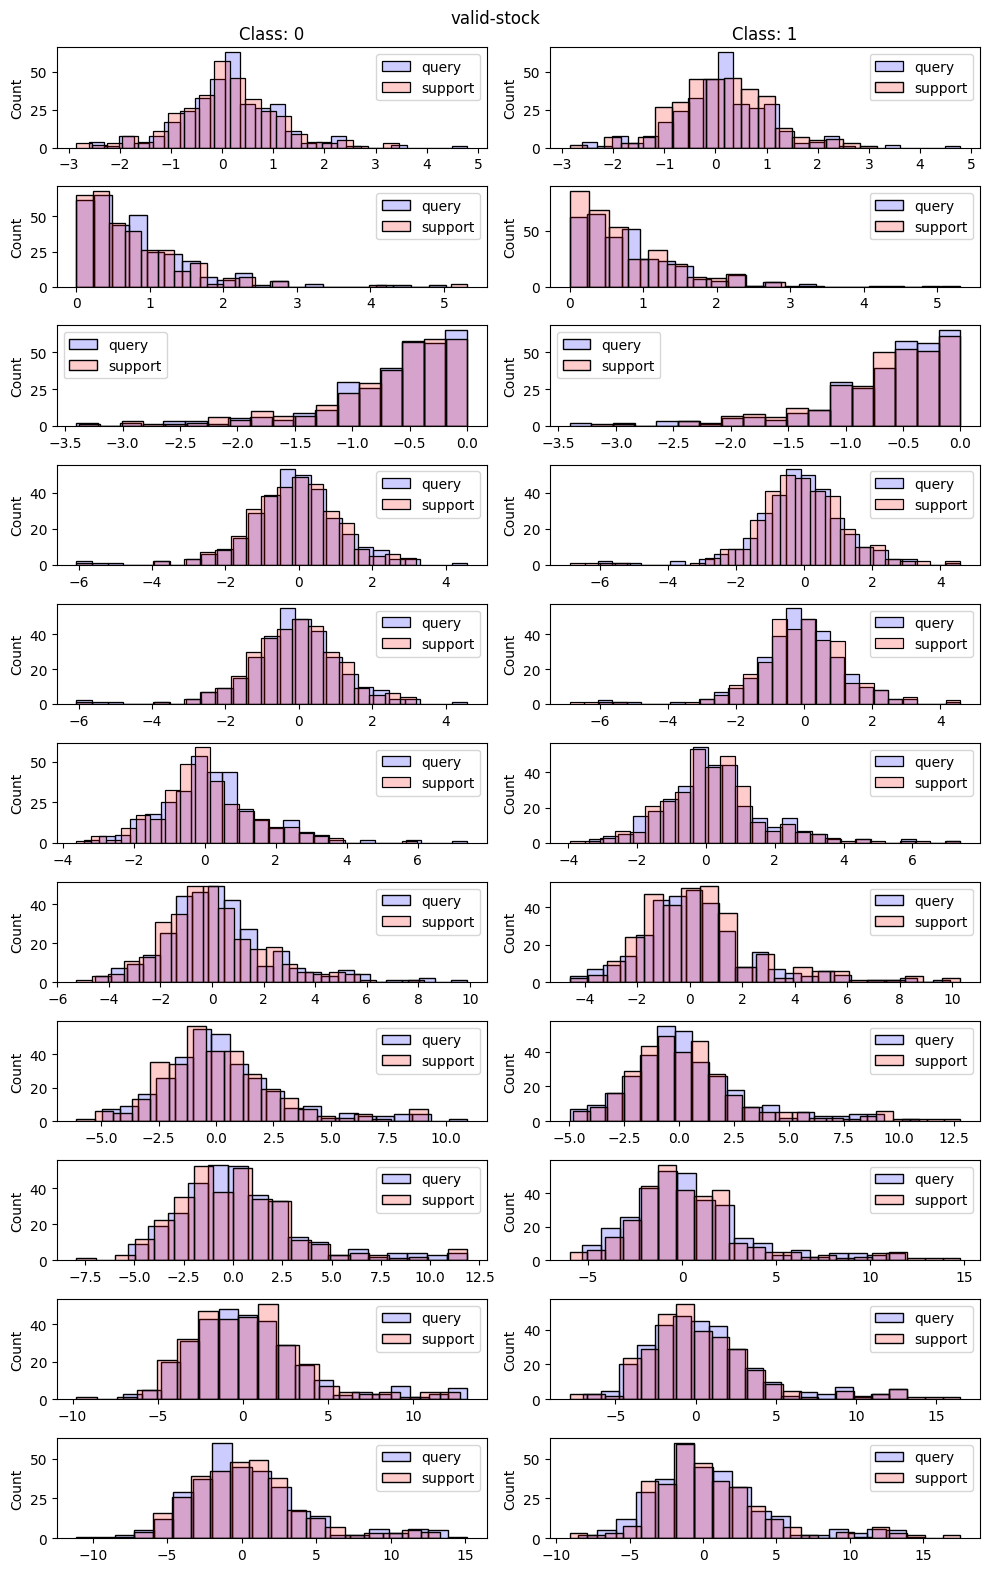

In [36]:
draw_density(ds=meta_valid_stock)

data distribution

In [5]:
from collections import Counter

def count_labels(meta_ds):
    cnts = Counter()
    for s in meta_ds.symbols:
        t = meta_ds.data[s].loc[meta_ds.candidates[s], 'label'].value_counts().to_dict()
        cnts.update(t)
    return cnts

cnt_data = {'ds': [], 'n_stock': [], 'fall': [], 'rise': []}
for ds in [meta_train, meta_valid_time, meta_valid_stock, meta_valid_mix, meta_test_time, meta_test_stock, meta_test_mix]:
    cnts = count_labels(ds)
    cnt_data['ds'].append(ds.meta_type)
    cnt_data['n_stock'].append(len(ds.symbols))
    cnt_data['fall'].append(cnts[0])
    cnt_data['rise'].append(cnts[1])
df_cnt = pd.DataFrame(cnt_data)
df_cnt

,ds,n_stock,fall,rise
0,train,60,6993,7089
1,valid-time,60,999,805
2,valid-stock,18,2160,2108
3,valid-mix,18,309,231
4,test-time,60,1266,1308
5,test-stock,9,994,1021
6,test-mix,9,198,204


In [23]:
# q dist
from tqdm import tqdm

def plot_q_dist(meta_dataset):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    idx = np.arange(max(meta_dataset.q_dist.keys()))
    values = [meta_dataset.q_dist[i] if meta_dataset.q_dist.get(i) else 0 for i in idx]

    ax.bar(idx, values)
    ax.set_xlabel('Query index in labels')
    ax.set_ylabel('Count')
    ax.set_title(f'Meta Type: {meta_dataset.meta_type}')
    plt.tight_layout()
    return fig

In [7]:
meta_train.reset_q_idx_dist()
n = 1000
for i in tqdm(range(n), total=n):
    meta_train.generate_tasks()

100%|██████████| 1000/1000 [00:13<00:00, 76.88it/s]


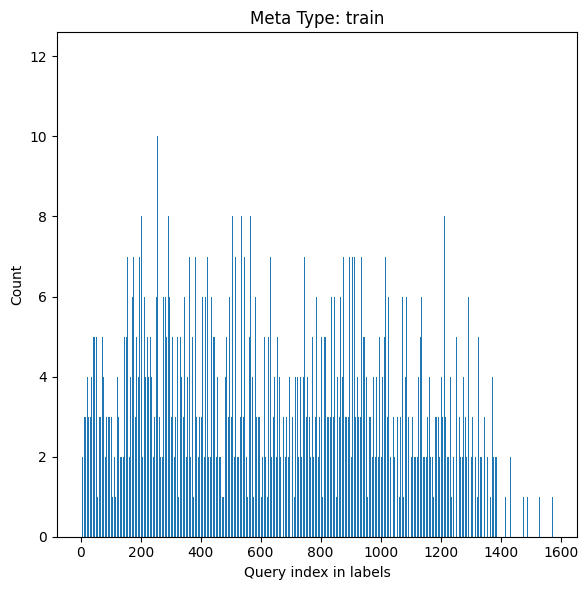

In [24]:
fig = plot_q_dist(meta_train)

In [3]:
meta_train.data.keys()

dict_keys(['CELG', 'UN', 'EXC', 'WFC', 'LMT', 'MO', 'BUD', 'SRE', 'CSCO', 'MA', 'MCD', 'CAT', 'CMCSA', 'GE', 'PEP', 'DUK', 'HD', 'BHP', 'XOM', 'SPLP', 'PCLN', 'BCH', 'HRG', 'T', 'SLB', 'BSAC', 'DIS', 'REX', 'GOOG', 'UTX', 'BRK-A', 'AAPL', 'MDT', 'AMZN', 'PG', 'C', 'BAC', 'FB', 'ABB', 'CHTR', 'GD', 'AEP', 'V', 'PTR', 'NEE', 'AGFS', 'KO', 'PM', 'AMGN', 'TSM', 'CODI', 'BBL', 'MRK', 'UPS', 'BP', 'MMM', 'SNP', 'NVS', 'PPL', 'VZ'])

In [5]:
meta_train.data['AAPL']

,date,open,high,low,close,adj_close,zd5,zd10,zd15,zd20,zd25,zd30,label
0,2014-01-02,0.461016,0.705080,-0.200673,-1.406368,-1.406374,0.976632,0.784095,0.801994,1.137088,0.818049,-0.321191,0
1,2014-01-03,2.196015,2.351282,-0.101672,-2.196585,-2.196572,2.397122,2.866640,2.814761,3.186525,3.138373,2.049545,0
2,2014-01-06,-1.191328,0.527645,-1.899144,0.545302,0.545268,1.247610,2.299036,2.053604,2.406590,2.564112,1.673408,2
3,2014-01-07,0.792532,1.096211,-0.392572,-0.715160,-0.715129,1.440621,2.869591,2.611034,2.959219,3.184129,2.522401,0
4,2014-01-08,-0.855636,0.386407,-0.877718,0.633286,0.633276,0.156035,1.732233,1.793082,2.099975,2.477612,2.022356,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,2015-07-27,0.260649,0.684210,-0.529440,-1.389561,-1.389568,2.370289,3.529370,2.538629,2.520979,2.771040,2.918742,0
394,2015-07-28,0.000000,0.429573,-0.672714,0.496864,0.496873,0.669472,2.836763,1.906844,1.967496,2.125786,2.314255,2
395,2015-07-29,0.130095,0.414669,-0.585414,-0.316096,-0.316104,0.626070,2.851456,2.252762,2.191646,2.318241,2.513758,2
396,2015-07-30,-0.040862,0.163436,-0.539351,-0.504102,-0.504100,0.679903,2.870800,2.896133,2.536567,2.649012,2.898855,0


In [11]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('./test_writer')
writer.add_figure('b', fig)

---

## Data generator

In [8]:
window_size = 10
symbol = 'AAPL'
df_stock = meta_train.data[symbol]
# filter out unpossible candidates
labels_indices = meta_train.candidates[symbol] 
labels_indices = labels_indices[labels_indices >= window_size]

for i in range(len(labels_indices)):
    array = df_stock.loc[labels_indices, 'label'].loc[:(labels_indices[i])].to_numpy()
    if meta_train.check_condition(array):
        break

# satisfied condition label index | smallest support index | smallest query index
candidates = labels_indices[(i+1):]

In [9]:
labels_indices, candidates

(array([  10,   11,   12, ..., 1981, 1983, 1984], dtype=int64),
 array([  17,   18,   19, ..., 1981, 1983, 1984], dtype=int64))

In [18]:
len(candidates), len(df_stock)

(1454, 1985)

In [10]:
df_stock.loc[labels_indices].iloc[:10, -1:]

,label
10,1
11,0
12,1
13,1
14,0
17,1
18,0
19,1
22,1
24,1


In [15]:
data = dict(
    query = None,
    query_labels = None,
    support = None,
    support_labels = None,
)

q_target = np.random.choice(candidates)   # index in the dataframe
# for q_target in y_q:
    # Queries
q_idx = np.arange(len(labels_indices))[labels_indices == q_target][0]  # get the index of label data
q_end = np.array([q_target]) 
q_start = q_end - window_size
q_data, q_labels = meta_train.generate_data(df_stock, y_start=q_start, y_end=q_end)

data['query'] = q_data
data['query_labels'] = q_labels[0]  # (1,)

# Supports
s_fall, s_rise = meta_train.get_rise_fall(df_stock, labels_indices, idx=q_idx, n_select=meta_train.n_support)
s_end = np.concatenate([s_fall, s_rise])
s_start = s_end - window_size
s_data, s_labels = meta_train.generate_data(df_stock, y_start=s_start, y_end=s_end)

data['support'] = s_data
data['support_labels'] = s_labels  # (N*K,)

print()   
print(f'query index: {q_idx}({q_target}) = {df_stock.loc[q_target, "label"]}')
print(f'- start={q_start} end={q_end}')
print(f'support indices:')
print(f'- start={s_start} end={s_end}')
print(f'{df_stock.loc[s_end, "label"]}')



query index: 231(304) = 0
- start=[294] end=[304]
support indices:
- start=[288 281 293 292] end=[298 291 303 302]
298    0
291    0
303    1
302    1
Name: label, dtype: int64


---

## Check queries distribution

In [8]:
from collections import Counter
window_size = 10
def get_q_label_dist(ds):
    q_label_dist = Counter()
    for symbol in ds.symbols:
        df_stock = ds.data[symbol]
        # filter out unpossible candidates
        labels_indices = ds.candidates[symbol] 
        labels_indices = labels_indices[labels_indices >= window_size]

        for i in range(len(labels_indices)):
            array = df_stock.loc[labels_indices, 'label'].loc[:(labels_indices[i])].to_numpy()
            if ds.check_condition(array):
                break
        candidates = labels_indices[(i+1):]  # query candidates
        
        counts = df_stock.loc[candidates, 'label'].value_counts().to_dict()
        q_label_dist.update(counts)
    
    return q_label_dist

In [9]:
q_label_dists = {'type': [], 'fall': [], 'rise': []}
for ds in [meta_train, meta_valid_time, meta_valid_stock, meta_valid_mix, 
    meta_test_time, meta_test_stock, meta_test_mix]:
    q_label_dist = get_q_label_dist(ds)
    q_label_dists['type'].append(ds.meta_type)
    q_label_dists['fall'].append(q_label_dist[0])
    q_label_dists['rise'].append(q_label_dist[1])

q_label_dists = pd.DataFrame(q_label_dists)

In [10]:
q_label_dists

,type,fall,rise
0,train,6449,6670
1,valid-time,439,404
2,valid-stock,1991,1982
3,valid-mix,122,114
4,test-time,868,702
5,test-stock,919,949
6,test-mix,140,117


---

# Modeling

In [14]:
import torch
import torch.nn as nn
from src.model import MetaModel

model_kwargs = meta_args.get_args(cls=MetaModel)
model = MetaModel(**model_kwargs)

rt_attn = True

## Forward

### forward_encoder

In [15]:
# encode_lstm
l, attn = model.encode_lstm(s_inputs, rt_attn=rt_attn)  # lstm_encoded: (B, N*K, E)
print(f'`l` Outputs: {l.size()}, {attn.size()}')
print(l[0])

`l` Outputs: torch.Size([5, 4, 5]), torch.Size([5, 4, 5])
tensor([[-1.0755,  0.8342, -1.3201,  1.0824,  0.4789],
        [-0.7977,  1.1047, -1.5387,  0.5298,  0.7018],
        [-1.2502,  0.8341, -1.1349,  1.1266,  0.4245],
        [-0.9094,  0.9294, -1.4812,  0.8805,  0.5806]],
       grad_fn=<SelectBackward0>)


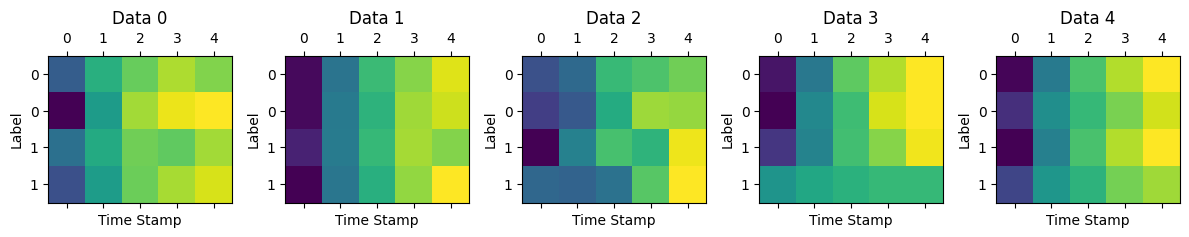

In [16]:
import matplotlib.pyplot as plt

if isinstance(attn, torch.Tensor):
    attn_numpy = attn.detach().numpy()
else:
    attn_numpy = attn
masks = [0, 0, 1, 1]

B = attn_numpy.shape[0]
fig, axes = plt.subplots(1, B, figsize=(12, 10))
for i in range(B):
    ax = axes[i]
    ax.matshow(attn_numpy[i])
    ax.set_title(f'Data {i}')

for ax in axes:
    ax.set_yticks(np.arange(len(masks)))
    ax.set_yticklabels(masks)
    ax.set_ylabel('Label')
    ax.set_xlabel('Time Stamp')
plt.tight_layout()
plt.show()

In [17]:
# encode_linear
# Reshape the size
B = l.size(0)
N = model.output_size
K = l.size(1) // N
if rt_attn:
    attn = attn.view(B, N, K, -1)  # attn: (B, N, K, T)
l_reshape = l.view(B, N, K, -1)  # l_reshape: (B, N, K, E)
e = model.encoder(l_reshape)  # e: (B, N, K, H)
print(f'`encoded` Outputs: {e.size()}')
print(e[0])

`encoded` Outputs: torch.Size([5, 2, 2, 3])
tensor([[[-0.0325,  0.4787, -0.6320],
         [ 0.3437,  0.2997, -0.4771]],

        [[-0.1893,  0.5647, -0.6558],
         [ 0.1624,  0.3811, -0.5737]]], grad_fn=<SelectBackward0>)


Relation Net: class-conditional multivariate Gaussian distribution with a diagonal covariance

The paper concatenate tensors for relation net inputs.

Let $R(x_{i}^{p}, x_{j}^{q})$ to represent the inputs of hidden state on concatenated relations between classes, $i, j$ for shot index, $p, q$ for class index.

The tensor shape is $(B, N^2, K^2, 2H)$. For each data(row) in $B$, the data relationship is $\sum_{i, j}^N \sum_{p, q}^{K} R(x_{i}^{p}, x_{j}^{q})$

e.g.,  N way K shot = 2 way 2 shot

| Relation | Left | Right |
|---|---|---|
| $R(x_0^0, x_0^0)$ | $h_{K_0}^{N_0}$ | $h_{K_0}^{N_0}$ |
| $R(x_0^0, x_1^0)$ | $h_{K_0}^{N_0}$ | $h_{K_1}^{N_0}$ | 
| $R(x_1^0, x_1^0)$ | $h_{K_1}^{N_0}$ | $h_{K_0}^{N_0}$ |
| $R(x_1^0, x_0^0)$ | $h_{K_1}^{N_0}$ | $h_{K_1}^{N_0}$ | 
| | | |
| $R(x_0^0, x_0^1)$ | $h_{K_0}^{N_0}$ | $h_{K_0}^{N_1}$ |
| $R(x_0^0, x_1^1)$ | $h_{K_0}^{N_0}$ | $h_{K_1}^{N_1}$ | 
| $R(x_1^0, x_1^1)$ | $h_{K_1}^{N_0}$ | $h_{K_0}^{N_1}$ |
| $R(x_1^0, x_0^1)$ | $h_{K_1}^{N_0}$ | $h_{K_1}^{N_1}$ | 
| | | |
| $R(x_0^1, x_0^0)$ | $h_{K_0}^{N_1}$ | $h_{K_0}^{N_0}$ |
| $R(x_0^1, x_1^0)$ | $h_{K_0}^{N_1}$ | $h_{K_1}^{N_0}$ | 
| $R(x_1^1, x_1^0)$ | $h_{K_1}^{N_1}$ | $h_{K_0}^{N_0}$ |
| $R(x_1^1, x_0^0)$ | $h_{K_1}^{N_1}$ | $h_{K_1}^{N_0}$ | 
| | | |
| $R(x_0^1, x_0^1)$ | $h_{K_0}^{N_1}$ | $h_{K_0}^{N_1}$ |
| $R(x_0^1, x_1^1)$ | $h_{K_0}^{N_1}$ | $h_{K_1}^{N_1}$ | 
| $R(x_1^1, x_1^1)$ | $h_{K_1}^{N_1}$ | $h_{K_0}^{N_1}$ |
| $R(x_1^1, x_0^1)$ | $h_{K_1}^{N_1}$ | $h_{K_1}^{N_1}$ | 

In [18]:
# e.g.
a = torch.randn(1, 2, 2, 3)
left = torch.repeat_interleave(a, 2, dim=2)
left = torch.repeat_interleave(left, 2, dim=1)
right = a.repeat((1, 2, 2, 1))
temp = torch.cat([left, right], dim=-1)
temp

tensor([[[[-0.0247, -0.8072, -1.6896, -0.0247, -0.8072, -1.6896],
          [-0.0247, -0.8072, -1.6896,  0.8147,  0.1862,  1.3567],
          [ 0.8147,  0.1862,  1.3567, -0.0247, -0.8072, -1.6896],
          [ 0.8147,  0.1862,  1.3567,  0.8147,  0.1862,  1.3567]],

         [[-0.0247, -0.8072, -1.6896,  0.9556, -0.5343, -1.0513],
          [-0.0247, -0.8072, -1.6896, -1.8305,  0.2426,  0.4125],
          [ 0.8147,  0.1862,  1.3567,  0.9556, -0.5343, -1.0513],
          [ 0.8147,  0.1862,  1.3567, -1.8305,  0.2426,  0.4125]],

         [[ 0.9556, -0.5343, -1.0513, -0.0247, -0.8072, -1.6896],
          [ 0.9556, -0.5343, -1.0513,  0.8147,  0.1862,  1.3567],
          [-1.8305,  0.2426,  0.4125, -0.0247, -0.8072, -1.6896],
          [-1.8305,  0.2426,  0.4125,  0.8147,  0.1862,  1.3567]],

         [[ 0.9556, -0.5343, -1.0513,  0.9556, -0.5343, -1.0513],
          [ 0.9556, -0.5343, -1.0513, -1.8305,  0.2426,  0.4125],
          [-1.8305,  0.2426,  0.4125,  0.9556, -0.5343, -1.0513],
    

after relation network, average the values for each class for all shots($K$)

e.g.,  N way K shot = 2 way 2 shot

| Class | Relation |
|---|---|
| 0 | $f\big( R(x_0^0, x_0^0) \big)$ |
| 0 | $f\big( R(x_0^0, x_1^0) \big)$ |
| 0 | $f\big( R(x_1^0, x_1^0) \big)$ |
| 0 | $f\big( R(x_1^0, x_0^0) \big)$ | 
| 0 | $f\big( R(x_0^0, x_0^1) \big)$ |
| 0 | $f\big( R(x_0^0, x_1^1) \big)$ |
| 0 | $f\big( R(x_1^0, x_1^1) \big)$ |
| 0 | $f\big( R(x_1^0, x_0^1) \big)$ |
|   | |
| 1 | $f\big( R(x_0^1, x_0^0) \big)$ | 
| 1 | $f\big( R(x_0^1, x_1^0) \big)$ | 
| 1 | $f\big( R(x_1^1, x_1^0) \big)$ | 
| 1 | $f\big( R(x_1^1, x_0^0) \big)$ |
| 1 | $f\big( R(x_0^1, x_0^1) \big)$ |
| 1 | $f\big( R(x_0^1, x_1^1) \big)$ |
| 1 | $f\big( R(x_1^1, x_1^1) \big)$ |
| 1 | $f\big( R(x_1^1, x_0^1) \big)$ |

In [19]:
# e.g., if relation net is identity function, the output is
temp.view(1, 2, 2*2*2, 6)

tensor([[[[-0.0247, -0.8072, -1.6896, -0.0247, -0.8072, -1.6896],
          [-0.0247, -0.8072, -1.6896,  0.8147,  0.1862,  1.3567],
          [ 0.8147,  0.1862,  1.3567, -0.0247, -0.8072, -1.6896],
          [ 0.8147,  0.1862,  1.3567,  0.8147,  0.1862,  1.3567],
          [-0.0247, -0.8072, -1.6896,  0.9556, -0.5343, -1.0513],
          [-0.0247, -0.8072, -1.6896, -1.8305,  0.2426,  0.4125],
          [ 0.8147,  0.1862,  1.3567,  0.9556, -0.5343, -1.0513],
          [ 0.8147,  0.1862,  1.3567, -1.8305,  0.2426,  0.4125]],

         [[ 0.9556, -0.5343, -1.0513, -0.0247, -0.8072, -1.6896],
          [ 0.9556, -0.5343, -1.0513,  0.8147,  0.1862,  1.3567],
          [-1.8305,  0.2426,  0.4125, -0.0247, -0.8072, -1.6896],
          [-1.8305,  0.2426,  0.4125,  0.8147,  0.1862,  1.3567],
          [ 0.9556, -0.5343, -1.0513,  0.9556, -0.5343, -1.0513],
          [ 0.9556, -0.5343, -1.0513, -1.8305,  0.2426,  0.4125],
          [-1.8305,  0.2426,  0.4125,  0.9556, -0.5343, -1.0513],
        

In [20]:
# relation_net
hs = model.relation_net(e)  # hs: (B, N, 2H)
print(f'`hs` Outputs: {hs.size()}')
print(hs[0])

`hs` Outputs: torch.Size([5, 2, 6])
tensor([[0.0000, 0.0000, 0.0072, 0.0006, 0.0313, 0.0201],
        [0.0000, 0.0000, 0.0110, 0.0000, 0.0478, 0.0383]],
       grad_fn=<SelectBackward0>)


In [21]:
# sample: parameters of a probability distribution in a low-dimensional space z for each class
z, kld_loss = model.sample(hs, size=model.hidden_size)  # z: (B, N, H)
x = l.mean(1)  # x: (B, E)
print(f'`z` Outputs: {z.size()}')
print(z[0])
print()
print(f'`x` Outputs: {x.size()}')
print(x[0])

`z` Outputs: torch.Size([5, 2, 3])
tensor([[-0.2002, -0.4402,  0.8758],
        [ 0.7040, -1.4166,  0.9400]], grad_fn=<SelectBackward0>)

`x` Outputs: torch.Size([5, 5])
tensor([-1.0082,  0.9256, -1.3687,  0.9048,  0.5465],
       grad_fn=<SelectBackward0>)


### forward_decoder

In [22]:
# decode
parameters = model.decode(z)
print(f'`parameters` Outputs: {parameters.size()}')
print(parameters[0])

`parameters` Outputs: torch.Size([5, 2, 5])
tensor([[ 0.2528, -0.6938, -1.6654,  1.0655,  0.8195],
        [-0.6311,  1.3353,  2.9934, -1.1317, -0.5474]],
       grad_fn=<SelectBackward0>)


In [26]:
# predict
loss, score = model.predict(x, parameters, s_labels)
print(f'Loss = {loss:.4f}\nScores =\n{score}')

Loss = 3.7132
Scores =
tensor([[ 2.7942, -3.5480],
        [ 3.0059, -6.2314],
        [ 1.1042,  0.1904],
        [-4.7380, -2.4826],
        [-1.9945, -3.0739]], grad_fn=<SqueezeBackward1>)


In [30]:
total_loss, q_scores, s_attn, q_attn = model(
    data=data,
    rt_attn=True
)

In [31]:
total_loss

tensor(2.7112, grad_fn=<AddBackward0>)

In [15]:
s_l, s_z, kld_loss, s_attn = model.forward_encoder(s_inputs, rt_attn=rt_attn)

# initialize z', Forward Decoder
z_prime = s_z
s_loss, s_scores, parameters = model.forward_decoder(z=z_prime, l=s_l, labels=s_labels)
# inner adaptation to z
for i in range(5):
    z_prime.retain_grad()
    s_loss.backward(retain_graph=True)
    z_prime = z_prime - model.inner_lr * z_prime.grad.data
    s_loss, s_scores, parameters = model.forward_decoder(z=z_prime, l=s_l, labels=s_labels)

# Stop Gradient: 
# z_prime.requires_grad == False
# s_z.requires_grad == True
z_prime = z_prime.detach()  
z_loss = torch.mean((z_prime - s_z)**2)


In [22]:
model.loss_fn(s_scores, s_labels.view(-1))

tensor(-0.1696, grad_fn=<NllLossBackward0>)

In [21]:
model.recorder.update('Support_Accuracy', s_scores, s_labels.view(-1))

# Metrics

In [5]:
from collections import defaultdict
import torchmetrics as tm
from typing import Dict, Tuple, List
import torch
import torch.nn as nn

In [6]:
torch.manual_seed(4)

t = all_data['query_labels']
o = torch.randint(0, 2, size=t.size())
# o = torch.rand(size=t.size())
y_true = pd.Series(t.numpy(), name='Actual') 
y_pred = pd.Series(o.numpy(), name='Pred')
df_confusion = pd.crosstab(y_true, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

Predicted,0,1,All
Actual,,,
0,23,12,35
1,12,17,29
All,35,29,64


In [7]:
# recall 
df_confusion = pd.crosstab(y_true, y_pred, rownames=['Actual'], colnames=['Predicted'])
precision = df_confusion.values.diagonal() / df_confusion.sum(0)
recall = df_confusion.values.diagonal() / df_confusion.sum(1)
print(precision.rename('Precision'))
print(recall.rename('Recall'))

Predicted
0    0.657143
1    0.586207
Name: Precision, dtype: float64
Actual
0    0.657143
1    0.586207
Name: Recall, dtype: float64


In [8]:
precision_tm = tm.Precision(num_classes=2, average=None)
p = precision_tm(o, t)

recall_tm = tm.Recall(num_classes=2, average=None)
r = recall_tm(o, t)

print(p)
print(r)

tensor([0.6571, 0.5862])
tensor([0.6571, 0.5862])


In [9]:
class MetricRecorder(nn.Module):
    def __init__(self):
        super().__init__()
        cs = tm.MetricCollection({
            'Accuracy': tm.Accuracy(), 
            'Precision': tm.Precision(num_classes=2, average=None), 
            'Recall': tm.Recall(num_classes=2, average=None), 
            'Loss': tm.SumMetric()
        })
        self.metrics = tm.MetricCollection([
            cs.clone('Support_'), cs.clone('Query_'), cs.clone('Finetune_'),
            tm.MetricCollection({
                'Inner': tm.MeanMetric(), 'Finetuning': tm.MeanMetric()
            }, postfix='_LR'),
            tm.MetricCollection({
                'Total': tm.SumMetric(), 
                'KLD': tm.SumMetric(), 
                'Z': tm.SumMetric(),
                'Orthogonality': tm.SumMetric()
            }, postfix='_Loss')
        ])

    @property
    def keys(self):
        return list(self.metrics.keys())

    def update(self, key, scores=None | torch.FloatTensor, targets=None | torch.LongTensor):
        if key.split('_')[-1] in ['Accuracy', 'Precision', 'Recall']:
            if targets is None:
                raise KeyError('Must insert `targets` to calculate accuracy.')
            self.metrics[key].update(scores, targets)
        else:
            self.metrics[key].update(scores)

    def compute(self, prefix: str):
        results = {}
        for k in self.keys:
            m = self.metrics[k].compute()
            if isinstance(m, torch.Tensor):
                m = m.cpu().detach().numpy()
            results[f'{prefix}-{k}'] = m
        return results

    def reset(self):
        for k in self.keys:
            self.metrics[k].reset()

    def extract_query_loss_acc(self, logs: Dict[str, float] | List[Dict[str, float]]) -> Dict[str, Tuple[float, float]]:
        to_filter = ['Query_Accuracy', 'Query_Loss']
        check_func = lambda x: sum([1 if f in x[0] else 0 for f in to_filter if f in x[0]])
        if isinstance(logs, dict):
            # cumulated logs
            filtered = dict(filter(check_func, logs.items()))
        else:
            filtered = {}
            for l in logs:
                win_filtered = dict(filter(check_func, l.items()))
                filtered.update(win_filtered)
        return filtered

In [10]:
recorder = MetricRecorder()
recorder.reset()  
print(recorder.keys)

['Support_Accuracy', 'Support_Loss', 'Support_Precision', 'Support_Recall', 'Query_Accuracy', 'Query_Loss', 'Query_Precision', 'Query_Recall', 'Finetune_Accuracy', 'Finetune_Loss', 'Finetune_Precision', 'Finetune_Recall', 'Finetuning_LR', 'Inner_LR', 'KLD_Loss', 'Orthogonality_Loss', 'Total_Loss', 'Z_Loss']


In [11]:
import torch
import torch.nn as nn
from src.model import MetaModel

model_kwargs = meta_args.get_args(cls=MetaModel)
model = MetaModel(**model_kwargs)

In [12]:
loss, preds, *_ = model(all_data)
logs = model.recorder.compute(prefix='Valid-Time')

In [19]:
valid_logs = defaultdict(list)

In [22]:
for log_string, value in logs.items():
    # Precision, Recall: (2)
    valid_logs[log_string].append(value)

In [15]:
np.mean(valid_logs['Valid-Time-Support_Accuracy'])

0.5104167

In [23]:
for k, v in valid_logs.items():
    if k.split('_')[-1] in ['Precision', 'Recall']:
        valid_logs[k] = (np.mean(v, axis=0), np.std(v, axis=0))
    else:
        valid_logs[k] = (np.mean(v), np.std(v))

In [24]:
valid_logs['Valid-Time-Support_Precision']

(array([0.51123595, 0.50970876], dtype=float32),
 array([0., 0.], dtype=float32))

In [84]:
scores = torch.FloatTensor([[0.0, 0.0], [0.0, 0.0]])
targets = torch.LongTensor([0, 0])
loss = torch.FloatTensor([0.0, 0.0])
lr = 0.276

recorder.update('Support_Accuracy', scores, targets) #
recorder.update('Support_Loss', loss)#
recorder.update('Query_Accuracy', scores, targets) #
recorder.update('Query_Loss', loss) #
recorder.update('Finetune_Accuracy', scores, targets) #
recorder.update('Finetune_Loss', loss) #
recorder.update('Finetuning_LR', lr) #
recorder.update('Inner_LR', lr) #
recorder.update('KLD_Loss', loss) #
recorder.update('Orthogonality_Loss', loss)  # 
recorder.update('Total_Loss', loss) #
recorder.update('Z_Loss', loss) #

In [85]:
recorder.compute()

{'Support_Accuracy': array(1., dtype=float32),
 'Support_Loss': array(0., dtype=float32),
 'Query_Accuracy': array(1., dtype=float32),
 'Query_Loss': array(0., dtype=float32),
 'Finetune_Accuracy': array(1., dtype=float32),
 'Finetune_Loss': array(0., dtype=float32),
 'Finetuning_LR': array(0.276, dtype=float32),
 'Inner_LR': array(0.276, dtype=float32),
 'KLD_Loss': array(0., dtype=float32),
 'Orthogonality_Loss': array(0., dtype=float32),
 'Total_Loss': array(0., dtype=float32),
 'Z_Loss': array(0., dtype=float32)}

In [41]:
recorder.update_window_metrics(5)

In [42]:
scores = torch.FloatTensor([[0.4, 1.2], [3.1, 1.2]])
targets = torch.LongTensor([1, 0])
loss = torch.FloatTensor([1.7, 1.6])
lr = 0.14

recorder.update('Support_Accuracy', scores, targets) #
recorder.update('Support_Loss', loss)#
recorder.update('Query_Accuracy', scores, targets) #
recorder.update('Query_Loss', loss) #
recorder.update('Finetune_Accuracy', scores, targets) #
recorder.update('Finetune_Loss', loss) #
recorder.update('Finetuning_LR', lr) #
recorder.update('Inner_LR', lr) #
recorder.update('KLD_Loss', loss) #
recorder.update('Orthogonality_Loss', loss)  # 
recorder.update('Total_Loss', loss) #
recorder.update('Z_Loss', loss) #

In [43]:
recorder.compute()

{'Support_Accuracy': array(0.5, dtype=float32),
 'Support_Loss': array(10.4, dtype=float32),
 'Query_Accuracy': array(0.5, dtype=float32),
 'Query_Loss': array(10.4, dtype=float32),
 'Finetune_Accuracy': array(0.5, dtype=float32),
 'Finetune_Loss': array(10.4, dtype=float32),
 'Finetuning_LR': array(0.208, dtype=float32),
 'Inner_LR': array(0.208, dtype=float32),
 'KLD_Loss': array(10.4, dtype=float32),
 'Orthogonality_Loss': array(10.4, dtype=float32),
 'Total_Loss': array(10.4, dtype=float32),
 'Z_Loss': array(10.4, dtype=float32)}

In [44]:
recorder.update_window_metrics(10)

In [45]:
logs = recorder.get_log_data('Train')
logs

{'Train-Support_Accuracy': 0.25,
 'Train-Support_Loss': 10.399999618530273,
 'Train-Query_Accuracy': 0.25,
 'Train-Query_Loss': 10.399999618530273,
 'Train-Finetune_Accuracy': 0.25,
 'Train-Finetune_Loss': 10.399999618530273,
 'Train-Finetuning_LR': 0.24199999868869781,
 'Train-Inner_LR': 0.24199999868869781,
 'Train-KLD_Loss': 10.399999618530273,
 'Train-Orthogonality_Loss': 10.399999618530273,
 'Train-Total_Loss': 10.399999618530273,
 'Train-Z_Loss': 10.399999618530273}

In [47]:
recorder.extract_query_loss_acc(logs)

{'Train-Query_Accuracy': 0.25, 'Train-Query_Loss': 10.399999618530273}

---

## Universe

In [7]:
import json 
import numpy as np


In [44]:

def create_universe(seed, stock_names):
    stocks = {}
    np.random.seed(seed)
    all_idx = np.arange(len(ps))
    train_idx = np.random.choice(all_idx, size=(int(len(ps)*0.7)), replace=False)
    valid_test_idx = all_idx[~np.isin(all_idx, train_idx)]
    valid_idx = np.random.choice(valid_test_idx, size=(int(len(valid_test_idx)*(0.2/0.3))), replace=False)
    test_idx = valid_test_idx[~np.isin(valid_test_idx, valid_idx)]
    stocks['train'] = list(stock_names[train_idx])
    stocks['valid'] = list(stock_names[valid_idx])
    stocks['test'] = list(stock_names[test_idx])
    stocks['seed'] = seed
    return stocks

In [48]:
ps = list((meta_train.data_dir / 'kdd17/price_long_50').glob('*.csv'))
stock_names = np.array([p.name.rstrip('.csv') for p in ps])
stocks = create_universe(seed=7, stock_names=stock_names)

In [49]:
import json

with (meta_train.data_dir / 'kdd17'/ 'stock_universe.json').open('w') as file:
    json.dump(stocks, file)

In [50]:
ps = list((meta_train.data_dir / 'stocknet-dataset/price/raw').glob('*.csv'))
stock_names = np.array([p.name.rstrip('.csv') for p in ps])
stocks = create_universe(seed=7, stock_names=stock_names)

with (meta_train.data_dir / 'stocknet-dataset'/ 'stock_universe.json').open('w') as file:
    json.dump(stocks, file)

-------

In [ ]:
# 아래 필요없음

In [11]:
import json 
ps = list((meta_train.data_dir / 'kdd17/price_long_50').glob('*.csv'))
with (Path('../data').resolve() / 'kdd17/stock_universe.json').open('r') as file:
    universe_dict = json.load(file)

universe_key = 'known'
universe = universe_dict['0'][universe_key]
iterator = [p for p in ps if p.name.strip('.csv') in universe]

In [55]:
p = iterator[29]
stock_symbol = p.name.rstrip('.csv')
df_single = meta_train.load_single_stock(p)
df_single = df_single.loc[df_single["date"].between("2014-01-01", '2015-01-01')].reset_index(drop=True)

In [56]:
symbol = p.name.strip('.csv') # 'AMZN'
window_size = 5
n_support = 4
df_stock = meta_train.data[symbol]
labels_indices = meta_train.candidates[symbol]
labels_candidates = labels_indices[labels_indices >= window_size]
idx = meta_train.get_possible_idx(df_stock, labels_candidates)
labels_candidates = labels_candidates[idx:]

In [57]:
labels_candidates

array([  15,   16,   17, ..., 1982, 1983, 1984], dtype=int64)

In [60]:
df_stock.loc[:15, ['date', 'label']]

,date,label
0,2007-02-14,2
1,2007-02-15,0
2,2007-02-16,2
3,2007-02-20,2
4,2007-02-21,0
5,2007-02-22,2
6,2007-02-23,2
7,2007-02-26,2
8,2007-02-27,0
9,2007-02-28,1


In [61]:
y_q = np.array([labels_candidates[0]])
y_qs = y_q - window_size
query, query_labels = meta_train.generate_data(df_stock, y_start=y_qs, y_end=y_q)

In [62]:
y_qs

array([10], dtype=int64)

In [63]:
query.round(4)

array([[[-0.5848,  0.6405, -1.9772,  0.3073,  0.3073,  0.1392,  0.7574,
          0.9728,  1.0874,  0.943 ,  0.9697],
        [ 1.1299,  1.5819, -0.113 , -1.4202, -1.4202,  1.1243,  1.9407,
          2.2467,  2.4124,  2.2888,  2.3452],
        [ 0.8847,  1.0845, -0.1142, -1.017 , -1.017 ,  1.387 ,  2.5942,
          3.0403,  3.2848,  3.2297,  3.273 ],
        [-0.5072,  0.3099, -1.0989,  1.2842,  1.2842,  0.1071,  0.9862,
          1.5892,  1.8456,  1.8785,  1.8921],
        [ 0.    ,  0.6787, -0.2828, -0.3663, -0.3663,  0.2262,  1.0775,
          1.744 ,  2.0475,  2.1993,  2.1752]]])

In [64]:
df_stock.loc[10:14]

,date,open,high,low,close,adj_close,zd5,zd10,zd15,zd20,zd25,zd30,label
10,2007-03-01,-0.584793,0.640487,-1.977162,0.307265,0.307266,0.139237,0.757449,0.972802,1.087442,0.942961,0.969704,2
11,2007-03-02,1.129935,1.581912,-0.112997,-1.420212,-1.420211,1.124289,1.940672,2.246698,2.412423,2.288781,2.345161,0
12,2007-03-05,0.884695,1.084466,-0.114158,-1.016952,-1.016952,1.386984,2.594176,3.040332,3.284815,3.229709,3.273000,0
13,2007-03-06,-0.507188,0.309935,-1.098912,1.284249,1.284248,0.107070,0.986189,1.589176,1.845586,1.878530,1.892075,1
14,2007-03-07,0.000000,0.678725,-0.282814,-0.366303,-0.366304,0.226246,1.077489,1.743966,2.047510,2.199321,2.175243,2


In [26]:
df_stock.loc[:6, ['date', 'label']]

,date,label
0,2007-02-14,2
1,2007-02-15,0
2,2007-02-16,1
3,2007-02-20,0
4,2007-02-21,2
5,2007-02-22,2
6,2007-02-23,0


In [25]:
labels_candidates

array([   6,    7,    8, ..., 1982, 1983, 1984], dtype=int64)

In [38]:
def get_possible_idx(df_stock, labels_candidates):
    i = 0
    while i < len(labels_candidates):
        rise, fall = get_rise_fall(df_stock, labels_candidates, idx=i)
        if len(rise) + len(fall) == 4:
            break
        else:
            i += 1
    return i

def get_rise_fall(df_stock, labels_candidates, idx):
    df_check = df_stock.loc[labels_candidates[:idx], 'label'].sort_index(ascending=False)
    rise = df_check.index[df_check == meta_train.labels_dict['rise']][:(n_support // 2)].to_numpy()
    fall = df_check.index[df_check == meta_train.labels_dict['fall']][:(n_support // 2)].to_numpy()
    return rise, fall

In [39]:
# remove unpossible candidates
idx = get_possible_idx(df_stock, labels_candidates)
labels_candidates = labels_candidates[idx:]


In [41]:
y_q

array([[1277],
       [ 806],
       [ 407],
       [1164],
       [  66]], dtype=int64)

In [42]:
y_q = np.array(np.random.choice(labels_candidates, size=(5,), replace=False))
y_qs = y_q - window_size
query, query_labels = meta_train.generate_data(df_stock, y_start=y_qs, y_end=y_q)
support = []
support_labels = []
for q in y_q:
    q_idx = np.arange(len(labels_candidates))[labels_candidates == q][0]
    rise, fall = get_rise_fall(df_stock, labels_candidates, idx=q_idx)
    y_s = np.concatenate([fall, rise])
    y_ss = y_s - window_size
    data_s, label_s = meta_train.generate_data(df_stock, y_start=y_ss, y_end=y_s)
    data_s = np.array(data_s)
    support.append(data_s)
    support_labels.append(label_s)

In [45]:
for x in np.expand_dims(query_labels, 1):
    print(x)

[1]
[1]
[1]
[1]
[1]


In [46]:
x

array([1], dtype=uint8)

In [136]:
np.array(support).shape

(5, 4, 5, 11)

In [116]:
query_labels

[0, 1, 0, 1, 0]

In [120]:
q = y_q[0]
q_idx = np.arange(len(labels_candidates))[labels_candidates == q][0]
rise, fall = get_rise_fall(df_stock, labels_candidates, idx=q_idx)

In [124]:
y_s = np.concatenate([fall, rise])
y_ss = y_s - window_size

In [127]:
support, support_labels = meta_train.generate_data(df_stock, y_start=y_ss, y_end=y_s)


In [9]:
symbol = 'AMZN'
window_size = 5
n_shot = 2
df_stock = meta_train.data[symbol]
labels_indices = meta_train.candidates[symbol]
y_cand = labels_indices[labels_indices >= window_size]
n_rise = 0
n_fall = 0
support= []
support_sample = []
query = []
support_turn = True
query_turn = False
query_sample = []
for idx in y_cand:

    # ex. k = 2
    if support_turn and  n_rise < n_shot or n_fall < n_shot:
        if n_rise < 2 and df_stock['label'][idx] == 1:
            n_rise +=1
            support_sample.append(idx)
        elif n_fall < 2 and df_stock['label'][idx] == 0:
            n_fall +=1
            support_sample.append(idx)
        continue

    if n_rise == n_shot and n_fall == n_shot:
        support.append(support_sample)
        support_sample = []
        n_rise = 0
        n_fall = 0
        query_turn = True
        support_turn = False 

    if query_turn:
        query_sample.append(idx)
        query.append(query_sample)
        query_sample = []
        query_turn = False
        support_turn = True
        continue
support_idx_set = np.array(support)
query_idx_set = np.array(query)
print(len(support_idx_set), len(query_idx_set))

241 241


In [60]:
query_idx_set

array([[  14],
       [  20],
       [  28],
       [  52],
       [  57],
       [  63],
       [  71],
       [  77],
       [  83],
       [  89],
       [  95],
       [ 102],
       [ 112],
       [ 121],
       [ 128],
       [ 135],
       [ 144],
       [ 162],
       [ 168],
       [ 174],
       [ 181],
       [ 190],
       [ 196],
       [ 205],
       [ 211],
       [ 222],
       [ 239],
       [ 248],
       [ 253],
       [ 258],
       [ 268],
       [ 274],
       [ 279],
       [ 284],
       [ 291],
       [ 299],
       [ 304],
       [ 315],
       [ 321],
       [ 328],
       [ 336],
       [ 341],
       [ 350],
       [ 357],
       [ 364],
       [ 372],
       [ 377],
       [ 383],
       [ 389],
       [ 394],
       [ 401],
       [ 406],
       [ 411],
       [ 420],
       [ 427],
       [ 435],
       [ 443],
       [ 450],
       [ 455],
       [ 462],
       [ 467],
       [ 473],
       [ 479],
       [ 488],
       [ 493],
       [ 502],
       [ 5

In [6]:
labels_indices = self.candidates[symbol]
labels_candidates = labels_indices[labels_indices >= window_size]
y_s = np.array(sorted(np.random.choice(labels_candidates, size=(self.n_sample,), replace=False)))
y_ss = y_s-window_size
support, support_labels = self.generate_data(df_stock, y_start=y_ss, y_end=y_s)

# code for jumpped tags like [1(support), 0, 0, 1(query)]
# y_q = labels_indices[np.arange(len(labels_indices))[np.isin(labels_indices, y_s)] + self.n_lag]
y_q = y_s + self.n_lag
y_qs = y_s - window_size if self.keep_support_history else y_q - window_size
query, query_labels = self.generate_data(df_stock, y_start=y_qs, y_end=y_q)